In [121]:
import numpy as np
from matplotlib import pyplot as plt
from bruges.filters import ricker, rotate_phase
from scipy import linalg as la
from numpy.linalg import lstsq

from sklearn import linear_model
%matplotlib inline


In [122]:
def make_synthetic(rpp):
    dt = 0.002
    duration = rpp.size * dt -dt # seconds
    frequency = 60.0 # Hz

    test_wave = np.roll(rotate_phase(ricker(duration,dt, frequency), np.pi/3.0), -rpp.size/2 + 30)
    test_seis = np.convolve(test_wave, rpp, mode='full')[:rpp.size]
    
    return test_wave, test_seis
    

In [123]:
def spectral_division(rpp, seismic):
    
    seis_fft = np.fft.fft(seismic)
    ref_fft = np.fft.fft(rpp)

    wavelet_spec = seis_fft / ref_fft
    wavelet_div = np.fft.ifft(wavelet_spec)
    
    return wavelet_div
    

In [124]:
def wigner(rpp, seismic):
    
    opConvolve = la.toeplitz(rpp)
    wavelet = lstsq(opConvolve, seismic)[0]
    return wavelet     

# Read in the data

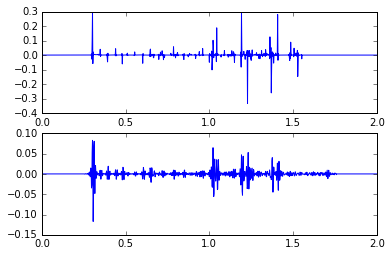

In [125]:
rpp = np.load("rpp.npy")
seismic = np.load("seismic.npy")

dt = .002
t = np.arange(seismic.size) * dt

plt.subplot(211)
plt.plot(t, rpp)
plt.subplot(212)
plt.plot(t, seismic)

# Unit test with convolution model and mixed phase.

This would be a cute example to show when autocorrelation and guessing the magnitude spectrum would fail.

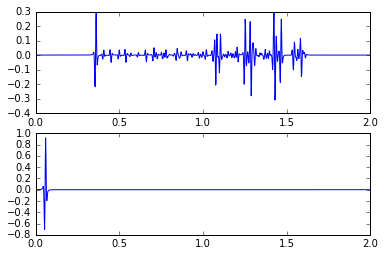

In [126]:
true_wave, synth = make_synthetic(rpp)
plt.subplot(211)
plt.plot(t, synth)
plt.subplot(212)
plt.plot(t, true_wave)

(0, 100)

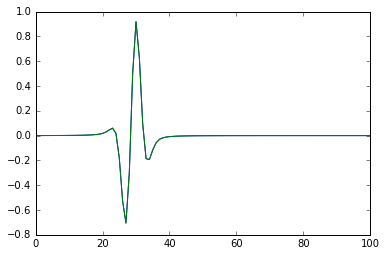

In [127]:
spec_div = spectral_division(rpp, synth)
plt.figure()
plt.plot(spec_div)
plt.plot(true_wave)
plt.xlim([0,100])

(0, 100)

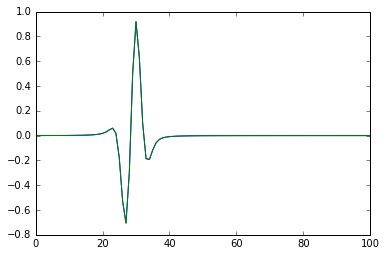

In [128]:
wigner_wave = wigner(rpp, synth)
plt.plot(wigner_wave)
plt.plot(true_wave)
plt.xlim([0,100])

Both methods recovered the wavelet exactly, which means the code passes the test

# Do it with the modelled and migrated data

True source. Not sure what wavelet changes happened during processing. I imagine thewas.
<img src="true_wave.png">

(0, 0.1)

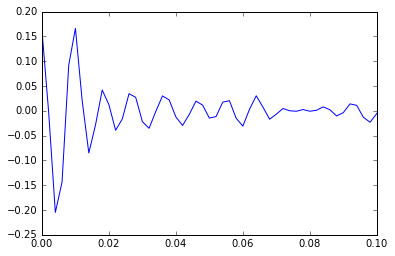

In [129]:
spec_div = spectral_division(rpp, seismic)
plt.figure()
plt.plot(t, spec_div)
plt.xlim([0,0.1])

(0, 0.1)

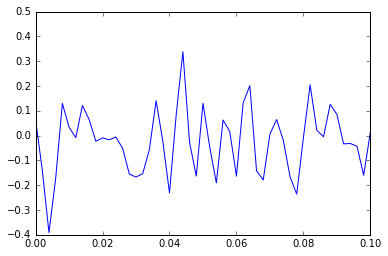

In [130]:
wigner_wave = wigner(rpp, seismic)
plt.plot(t,wigner_wave)
plt.xlim([0,.1])

Both methods give more or less gibberish, which basically shows that migrated seismic does not adhere to a convolutional model. Let's check the Spectra.

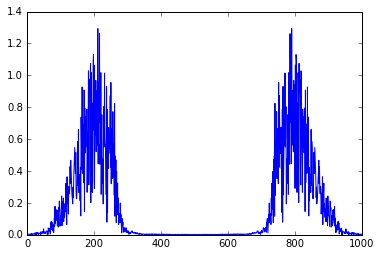

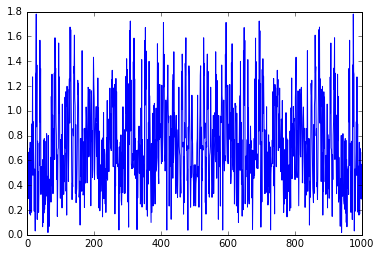

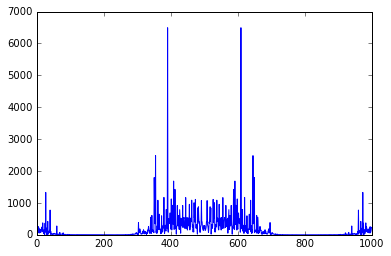

In [131]:
plt.figure()
plt.plot(np.abs(np.fft.fft(seismic)))
plt.figure()
plt.plot(np.abs(np.fft.fft(rpp)))
plt.figure()
plt.plot(np.abs(np.fft.fft(rpp) / np.fft.fft(seismic)))

Gross. Tons of variance and a spectrum that looks nothing like a wavelet. Basically we can't fit the data because a convolutional model sucks at modelling migrated seismic. Let's use some optimization tricks. Regularize the least squares problem and bias it towards an answer we want. Start with something simple, like an L2 norm. Basically we know a priori that we don't want ton of large spikes in our wavelet and an L2 norm will penalize these. Note ridge regression is just least-squares with an L2 penalty.

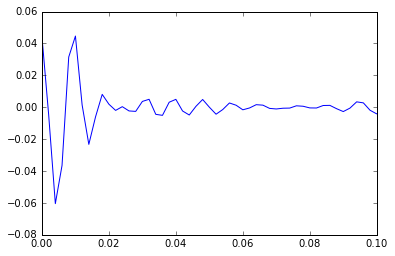

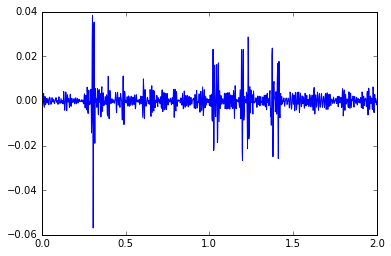

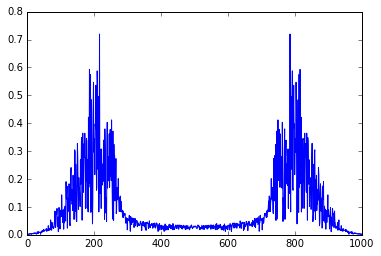

In [132]:
clf = linear_model.Ridge(alpha = 0.99, fit_intercept=False)
opConvolve = la.toeplitz(rpp)
op  = opConvolve
clf.fit(op, seismic)
wavelet = clf.coef_

plt.plot(t, wavelet)
plt.xlim([0,.1])

# modelled seismic
plt.figure()
plt.plot(t, np.dot(op, wavelet))

# Check the spectra
plt.figure()
plt.plot(np.abs(np.fft.fft(wavelet)))

Hey, not bad. Looks more like wavelet! The spectra has way less variance, but doing the regularization added some noise to our data. Such is life, when our model is wrong we always trade off between fitting the data and seeing what we want to see. 

Let's try some other tricks. We know the approximate length of the wavelet, and it definitely won't be two seconds long. Let's add a projection operator into the mix which forces all the wavelet energy to be in the first few samples.

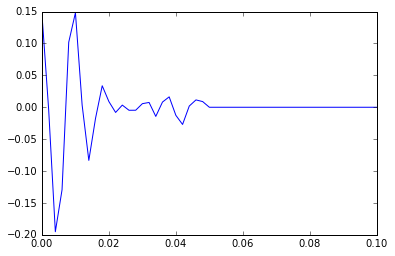

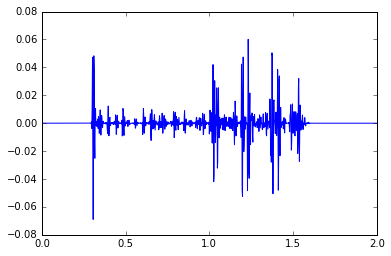

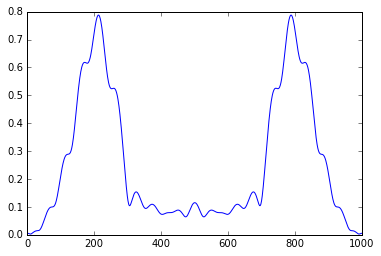

In [120]:
wavelet_size = 25 # samples
opProj = np.zeros((rpp.size, rpp.size))
opProj[:wavelet_size, :wavelet_size] = np.eye(wavelet_size)

op  = np.dot(opConvolve, opProj)
wavelet = lstsq(op, seismic)[0]
plt.plot(t, wavelet)
plt.xlim([0,.1])

# Check out the seismic under this model
plt.figure()
plt.plot(t, np.dot(op, wavelet))

# Check the spectra
plt.figure()
plt.plot(np.abs(np.fft.fft(wavelet)))

Sweet spectra, but it came at the cost of adding a large reflection at the end of the data. Anyways, there are a billion different ways to re-formulate the least-squares problem. It's actually at bit addictive. 

Take home: 
The basic convolution model can't fit the data. There are multiples, processing issues, and migrations effects that aren't accounted. Because the model is wrong we are going to get a wrong answer, so we use regularization and other optimization tricks so we at least get a wrong answer that looks legit. 

Something else to think about: 
This is synthetic data, and things are already messy and uncertain for even the simplest inversion. Things are obviously going to be total non-sense on real data. More complicated inversions like Shuey-terms, FWI, least-squares RTM... get real ;).